# Lecture 2: Spiral classification

Notebook adapted from [Deep Learning (with PyTorch)](https://github.com/Atcold/pytorch-Deep-Learning) by Alfredo Canziani. 

In [1]:
import numpy as np
import torch
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
# Plot functions
import matplotlib.pyplot as plt
from IPython import display
plt.rc('figure', figsize=(8, 8))

def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')
    
def plot_model(X, y, model):  
    model.cpu()
    
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3)
    plot_data(X, y)

In [36]:
# Setup
seed = 12345
torch.manual_seed(seed)

N = 100  # num_samples_per_class
D = 2    # dimensions
C = 2    # num_classes
H = 10000  # num_hidden_units

In [28]:
# Generate spiral data
X = torch.zeros(N * C, D).to(device)
y = torch.zeros(N * C, dtype=torch.long).to(device)

for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    # When c = 0 and t = 0: start of linspace
    # When c = 0 and t = 1: end of linpace
    # This inner_var is for the formula inside sin() and cos() like sin(inner_var) and cos(inner_Var)
    inner_var = torch.linspace(
        # When t = 0
        (2 * np.pi / C) * (c),
        # When t = 1
        (2 * np.pi / C) * (2 + c),
        N
    ) + torch.randn(N) * 0.2
    
    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor((
            np.sin(inner_var[index]), np.cos(inner_var[index])
        ))
        y[ix] = c
        index += 1

In [19]:
X.shape, y.shape

(torch.Size([200, 2]), torch.Size([200]))

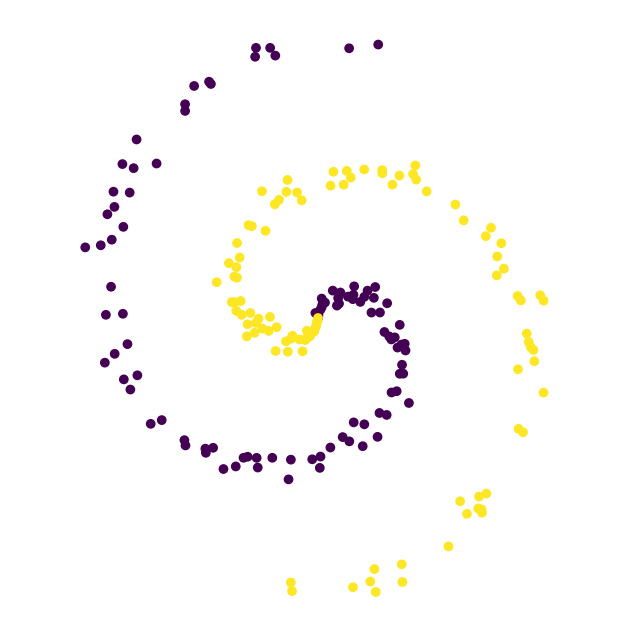

In [20]:
plot_data(X, y)

### Linear model

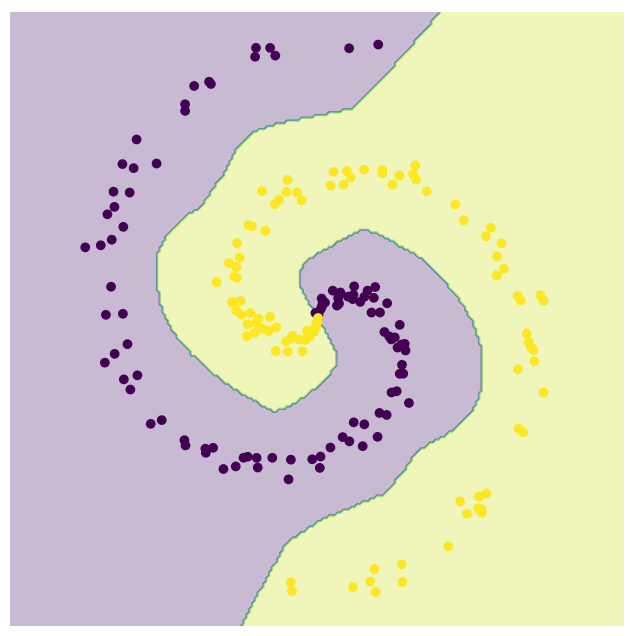

In [25]:
# we use the torch.nn package to create our linear model
# each Linear module has a weight and bias
model = torch.nn.Sequential(
    torch.nn.Linear(D, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, C)
)

# Convert to CUDA
model.to(device)  

# torhc.nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5) 

# Training
for t in range(1000):
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    
    if t % 25 == 0:
        plt.clf()
        plot_model(X, y, model)
        model.to(device)
        display.display(plt.gcf())
        print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
        display.clear_output(wait=True)
        
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

### MLP

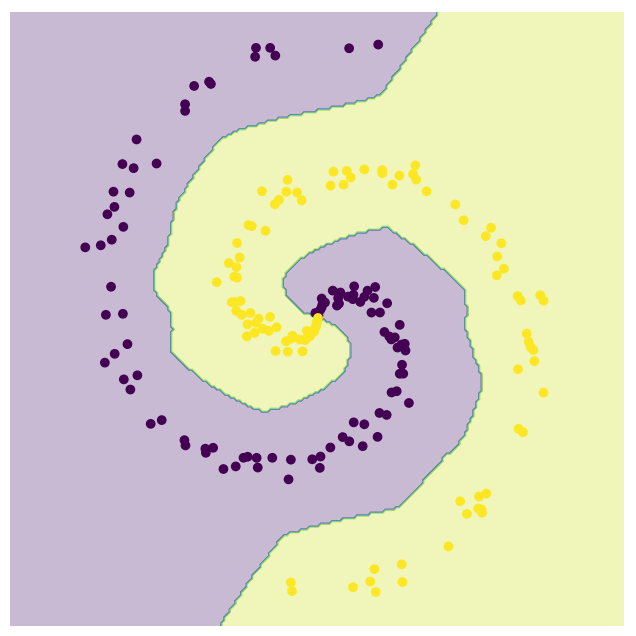

In [37]:
# nn package to create our linear model
# each Linear module has a weight and bias

model = torch.nn.Sequential(
    torch.nn.Linear(D, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, C)
)

# model = torch.nn.Sequential(
#     torch.nn.Linear(D, H),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H, H),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H, H),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H, H),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H, C)
# )

model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5) 

# Training
for t in range(2000):
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    
    if t % 25 == 0:
        plt.clf()
        plot_model(X, y, model)
        model.to(device)
        display.display(plt.gcf())
        print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
        display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()